# Sentiment Analysis Using Tensorflow
- Use Keras within Tensorflow to create a Recurrent Neural Network that can be used for Sentiment Classification

#### Data Sources
- Amazon reviews: reviews taken from amazon.com and prepared by the UCI Machine Learning Repository
- IMDB reviews: reviews taken from imdb.com and prepared by the UCI Machine Learning Repository
- Yelp reviews: reviews taken from yelp.com and prepared by the UCI Machine Learning Repository
- URL for above resources: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

#### Package/Module Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np 

# Model building and data preperation
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# Visualizations
import matplotlib.pyplot as plt

## Part I:  Research Question

A.  Describe the purpose of this data analysis:

The purpose of this analysis to to train a Recurrent Neural Network with the goal of accurately classifying text sentiments as positive or negative. This model will be used to help organizations answer questions about whether or not a product or service is receiving positive or negative remarks without needing to read every single review. This analysis will use a combination of reviews from Amazon, IMDB, and Yelp in an effort to create a robust model that can be applied outside of one type of product review. 

## Part II:  Data Preparation

In [2]:
# Load individual datasets
amazon = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None, encoding='UTF-8')
imdb = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, encoding='UTF-8')
yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None, encoding='UTF-8')

# Concatenate datasets into single dataframe
df = pd.concat([amazon, imdb, yelp])
df.columns = ['text', 'label']
df.reset_index(drop=True, inplace=True)

# Inspect Dataset
print('df shape ',df.shape,'\n')
print('Label Counts\n',df.label.value_counts())

df shape  (2748, 2) 

Label Counts
 1    1386
0    1362
Name: label, dtype: int64


#### 1.  Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:
To explore the text within the data set, a series of for-loops were used to tokenize the words in each sample and then add them to a set of unique words. A list of the sentences was also created to later be used in determining sequence length for the embedding layer of the neural network. 

The list of unique words consists of 4970 words. This list is of the alphabetical english words. The tokens that did not fit within these guidlines were added to the other_char set and consists of 384 tokens. This is mainly punctuation, digits, or words that have special characters misplaced or are spelled innaccurately.

For the neural network a word embedding length of 4500 will be used. Due to the small sample size and relatively low count of tokens this should not pose extra strain on the computation load. The list of sentences was used to create a boxplot showing the distribution of sentence lengths. There were some extreme outliers on the upper range. The boxplot showed the majority of the sentence lengths were less than 50 words. A second histogram was plotted with the maximum bin capping off at 50 words. The describe function was also used for a numerical representation of the range only using lengths that were less than 50 words. Using the histogram it was chosen to use a max sequence length of 34 words. This length is 3 standard deviations above the mean for the subset of lengths less than 50 words. This length allows for 98.5% of the sequences to be represented in full. 

In [3]:
# Create lists to store words and sentences
vocab = list()
sentences = list()
all_tokens = list()

# Loop through reviews to extract sentences and words
for sentence in df.text.values:
    # Tokenize in lowercase
    lower_tokens = [w for w in word_tokenize(sentence.lower())]
    # Add tokens to other_char
    for l in lower_tokens:
        all_tokens.append(l)
    # Retain only alphabetic words, remove punctuation
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    # append to list of sentences
    sentences.append(alpha_only)
    # add words from sentence to vocab list
    for a in alpha_only:
        vocab.append(a)

# create set of unique values from vocab list and other_char
vocab = set(vocab)
other_char = set(all_tokens) - vocab

print('Vocab Size: %s'%len(vocab))
print('Excluded Tokens: %s'%len(other_char))

Vocab Size: 4970
Excluded Tokens: 384


In [4]:
# Create list to store number of words in each sentence
sent_length = list()

# Loop through sentences and append length in words to sent_length
for s in sentences:
    sent_length.append(len(s))

# Convert to dataframe
sent_length = pd.DataFrame(sent_length)

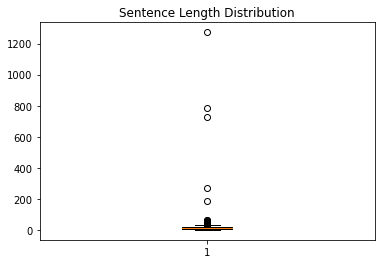

In [5]:
# Assess Distibution of Sentence Lengths
plt.boxplot(sent_length)
plt.title('Sentence Length Distribution')
plt.show()

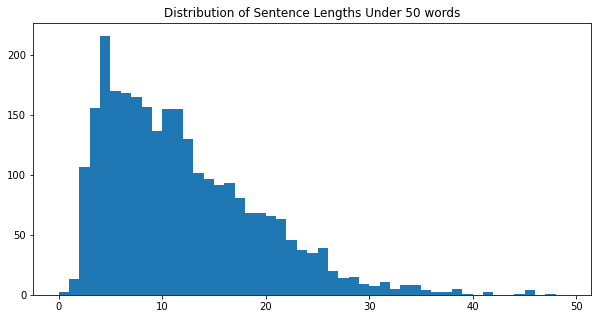

In [6]:
# plot histogram of sentence lengths under 50 words
bins = np.arange(0,50,1)
plt.figure(figsize=(10, 5))
plt.hist(sent_length, bins=bins)
plt.title('Distribution of Sentence Lengths Under 50 words')
plt.show()

In [7]:
# Display distribution stats for subset of length less than 50
sent_length[sent_length<50].describe()

,0
count,2737.000000
mean,11.449032
std,7.352923
min,0.000000
25%,6.000000
50%,10.000000
75%,16.000000
max,47.000000


In [8]:
# Calculate the length that is 3 standard deviations above the mean length for the subset
11.45 + (7.35*3)

33.5

In [9]:
perc_full = sent_length[sent_length<34].count() / sent_length.count()
print('Percent of Full Sequences Captured: %.3f'%perc_full)

Percent of Full Sequences Captured: 0.985


#### 2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.
The goal of the tokenization process is to convert the sequence of words into a numeric representation so that it is able to be used in a machine learning model. Here, the Tokenizer() API from Keras was used to transform the words into integers representing their index in the vocabulary dictionary created by the Tokenizer. 

#### 3.  Explain the padding process used to standardize the length of sequences, including the following in your explanation:
The data being fed into the machine learning model must have the same dimensions. Because not all sequences are the same length of words, we must determine a fixed sequence length to use. Using that length, we either cut off sequences that exceed this length, or pad sequences that are shorter. The end result is a list of sequences that contain the same number of values. Below is a sample taken from a padded sequence below. You can see that we have padded with leading zeros before the sequence if the sequence was shorter than the determined length of 34 values.

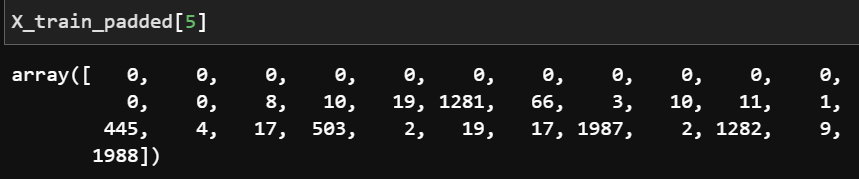

In [10]:
# Split data into training and testing
X = df['text']
y = df['label']
SEED = 830

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [11]:
# Tokenize training set using Tokenizer from Keras
vocab_size = 4500
tokenizer = Tokenizer(num_words=vocab_size)

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train.values)

# Create padded sequence of train data using tokenizer
X_train_token = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_token, maxlen=34)

# Create padded sequence of test data using tokenizer
X_test_token = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_token, maxlen=34)

print('Train shape: {}'.format(X_train_padded.shape))
print('Test shape: {}'.format(X_test_padded.shape))

Train shape: (2198, 34)
Test shape: (550, 34)


In [12]:
X_train_padded[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    8,   10,   19, 1281,   66,    3,   10,   11,    1,
        445,    4,   17,  503,    2,   19,   17, 1987,    2, 1282,    9,
       1988])

#### 4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.
This model will have two categories of sentiment classification. The acivation function in the final layer of the neural network will be sigmoid to predict the probability of belonging to Class 1 (positive sentiment) in the final node.

#### 5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split.
First, the data was separated into X and y sets. Second, the X and y sets were split into training and testing sets with 20% being set aside for testing. Validation data was not split off but 15% of the training data will be used in the training of the model using the 'validation_split' parameter when fitting the model. Next, a tokenizer was instantiated and fit on the X training data. This tokenizer was used to create feature vectors on the training and testing data. Finally, these sets were then padded with leading zeros and cut off with a maximum length of 34 values.

#### 6.  Provide a copy of the prepared dataset.

In [13]:
# Export training, validation and testing data to csv files
pd.DataFrame(X_train_padded).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test_padded).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

## Part III:  Network Architecture
A summary of the model architecture is provided below after fitting the model. 

The network was constructed with three layers: Embedding, LSTM, and Dense. The total parameters and trainable parameteres was 230,701. The embedding layer takes the inputs and creates dense vectors to be fed to the rest of the model. The LSTM layer is used to link the different sequences to the labels to determine what weights to use at each node. The LSTM layer has a regulation aspect to it by using "gates" within to ensure the gradients in each node do not "explode" or "vanish." This layer had the parameters "dropout" and "recurrent_dropout" set to 0.25 in an effort to avoid over fitting in the model. The final layer is a Dense layer with one output node and a sigmoid activation function. 

The model was compiled with an Adam optimizer as this is a very robust choice and is widely used and accepted. It also performed much better than models tested with SGD and RMSProp optimizers. Accuracy was used for the evaluation metric as we wanted to see how accuractely the model could classify each sentiment with its correct label. The binary_crossentropy loss function was used since this is a binary classification problem. An early stopping parameter was used to stop the model from fitting if the validation accuracy was not improving. 

In [14]:
# Load data into training and testing variables
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [15]:
# Instantiate the Neural Network Model
model = Sequential()

# Add layers to model
model.add(Embedding(input_dim=vocab_size, # Vocab size is defined above during tokenization
                    output_dim=50, 
                    trainable=True, 
                    input_length=34)) 
model.add(LSTM(20, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model on the training data, using 15% of it as validation. 
history = model.fit(X_train, y_train, 
                    validation_split=0.15, epochs=50,
                    callbacks=[early_stopping_monitor])

Epoch 1/50
59/59 [==============================] - 2s 37ms/step - loss: 0.6882 - accuracy: 0.6071 - val_loss: 0.6775 - val_accuracy: 0.6576
Epoch 2/50
59/59 [==============================] - 2s 29ms/step - loss: 0.5945 - accuracy: 0.7661 - val_loss: 0.5532 - val_accuracy: 0.7242
Epoch 3/50
59/59 [==============================] - 2s 29ms/step - loss: 0.3534 - accuracy: 0.8688 - val_loss: 0.5058 - val_accuracy: 0.7545
Epoch 4/50
59/59 [==============================] - 2s 29ms/step - loss: 0.1968 - accuracy: 0.9481 - val_loss: 0.4920 - val_accuracy: 0.7970
Epoch 5/50
59/59 [==============================] - 2s 30ms/step - loss: 0.1181 - accuracy: 0.9706 - val_loss: 0.5133 - val_accuracy: 0.7970
Epoch 6/50
59/59 [==============================] - 2s 30ms/step - loss: 0.0804 - accuracy: 0.9802 - val_loss: 0.5586 - val_accuracy: 0.7727


In [16]:
# Display Model Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            225000    
_________________________________________________________________
lstm (LSTM)                  (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 230,701
Trainable params: 230,701
Non-trainable params: 0
_________________________________________________________________


## Part IV:  Model Evaluation

#### 1.  Discuss the impact of using stopping criteria instead of defining the number of epochs, including a screenshot showing the final training epoch.
By specifying an early stopping criteria and a high number of epochs it allows the program to determine the cut off point for the best model. In this case, the model's validation loss stopped improving after 3 epochs and since the patience was set to 2, the program stopped fitting the model after the fifth epoch and saved the results of the third epoch in the model. 

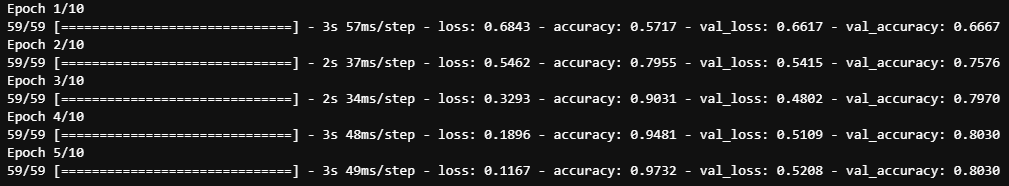

#### 2.  Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

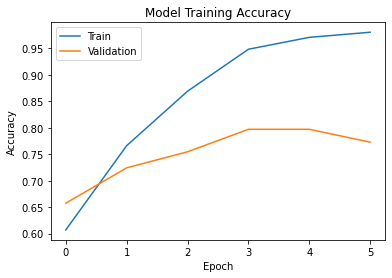

In [17]:
# Plot accuracy for training and Validation during model fitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

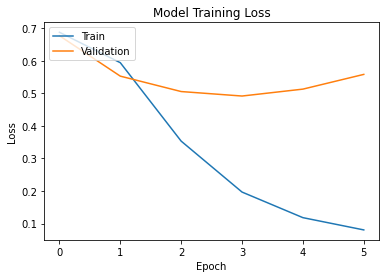

In [18]:
# Plot Loss for training and Validation during model fitting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### 3.  Assess the fitness of the model and any measures taken to address overfitting.
Although the model achieved an accuracy of just under 80% before the validation loss function began rising again, the model still shows signs of over fitting. The training accuracy continued improving along with the training loss even though methods such as dropout were used. Kernal regularization was also attempted to avoid overfitting but it showed no improvement so the model was reverted back for simplicity sake. 

#### 4.  Discuss the predictive accuracy of the trained network.
Shown below, the model was able to predict on the testing data with just over 82% accuracy. This is better than was able to be achieved in the training process on the validation data. 

In [19]:
# Evaluate the accuracy of the model on the test data
results = model.evaluate(X_test, y_test, verbose=0)
print('Model Testing Loss Function Value: %.3f'%results[0])
print('Model Testing accuracy: %.3f'%results[1])

Model Testing Loss Function Value: 0.527
Model Testing accuracy: 0.800


## Part V:  Summary and Recommendations
Code to save the model is provided below.

The model functions by taking a list of values representing words in a sequence and analyzing the sequence as a whole in the LSTM layer. The LSTM layer has gates built in to avoid vanishing or exploding gradients. Through the process of forward and backward propogation the weights are trained to find the optimal values to aid in the prediction of the clas of the sentiment. The outputs of the LSTM layer are finally fed to the Dense/Output layer to create a prediction which is the probability of the observation to be labeled as 1, or positive. If this probabilty is above 0.5 then it is classified as a one. The model was able to perform well although there is still room to grow from the 80% accuracy on the testing data.

I recommend the company begins using this model to assess sentiment in customer reviews for various products and services. One limitation of the model was the inability to avoid overfitting in the training process. To combat this more data should be collected and used to train a more robust model that can generalize well to new data. 

In [20]:
# Save the model
model.save('Sentiment_Analysis_RNN_5.15.2021')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Sentiment_Analysis_RNN_5.15.2021\assets
